## Model organ specific celltype signatures

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse
import anndata

## Load data + annotations

In [4]:
adata_full_raw = sc.read_h5ad("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_raw_count.wGut.h5ad")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
def _rename_gut_cells(x):
    if "FCA" not in x:
        x = x.split("_")[8].split('-')[1] + "-1"  + "_" + "_".join(x.split("_")[3:6])
    else: 
        x = x.split("_")[7].split('-')[1] + "-1" + "_" + "_".join(x.split("_")[3:5]) 
    return(x)

obs_names = adata_full_raw.obs_names.values
gut_ixs = np.where(adata_full_raw.obs.organ=="GU")[0]
for i in gut_ixs:
    obs_names[i] = _rename_gut_cells(obs_names[i])

adata_full_raw.obs_names = obs_names

In [2]:
adata_nkt = sc.read_h5ad("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210118.NKT_CLEAN.batchCorrected.h5ad")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
# adata_nkt_raw = sc.read_h5ad("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210118.NKT_CLEAN.h5ad")
adata_nkt_raw = sc.read_h5ad("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_raw_count.wGut.NKT_CLEAN.h5ad")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [13]:
adata_nkt_raw = adata_full_raw[adata_nkt.obs_names,]

In [14]:
# adata_nkt_raw.write_h5ad("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_raw_count.wGut.NKT_CLEAN.h5ad")

In [4]:
adata_nkt_raw.obsm = adata_nkt.obsm
adata_nkt_raw.uns = adata_nkt.uns
adata_nkt_raw.obsp = adata_nkt.obsp
adata_nkt_raw.obs = adata_nkt.obs

In [108]:
anno_b = pd.read_csv("../manual_annotation/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210118.B_CLEAN_CLEAN.batchCorrected_annotation.csv")

In [5]:
anno_nkt = pd.read_csv("../manual_annotation/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210118.NKT_CLEAN.batchCorrected_annotation.csv")
anno_nkt.index = anno_nkt['index']

In [6]:
adata_nkt_raw.obs = pd.concat([adata_nkt_raw.obs, anno_nkt], axis=1).loc[adata_nkt_raw.obs_names]

... storing 'anno_lvl_1' as categorical
... storing 'anno_lvl_2' as categorical
... storing 'anno_lvl_3' as categorical


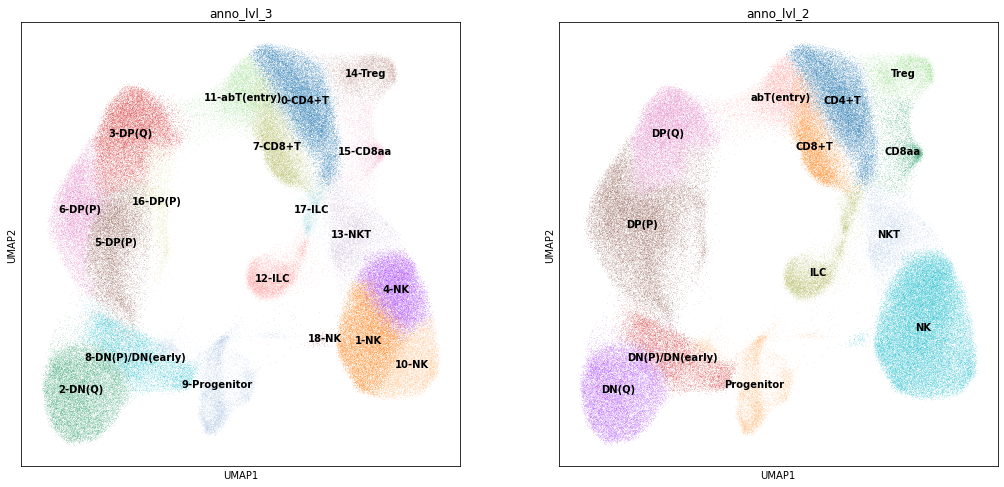

In [7]:
plt.rcParams["figure.figsize"] = [8,8]
sc.pl.umap(adata_nkt_raw, color=["anno_lvl_3", "anno_lvl_2"], legend_loc="on data")

In [8]:
adata_nkt_raw.var_names_make_unique()
adata_nkt.var_names_make_unique()

### GLMGamPoi

Following vignette at https://bioconductor.org/packages/release/bioc/vignettes/glmGamPoi/inst/doc/glmGamPoi.html#example

In [33]:
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging

In [34]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

Activate the anndata2ri conversion between SingleCellExperiment and AnnData

In [35]:
anndata2ri.activate()

In [36]:
%load_ext rpy2.ipython

In [37]:
%%R
# library(tidyverse)
library(ggplot2)
library(glmGamPoi)

Take a subset of genes

In [42]:
smp_cells = pd.DataFrame(adata_nkt_raw.obs_names).sample(5000)["index"]

In [46]:
adata_sub = adata_nkt_raw[smp_cells,adata_nkt.var_names]
# adata_sub = adata_nkt_raw[:,adata_nkt.var_names]


In [47]:
adata_sub.obs = adata_sub.obs[["anno_lvl_1", "anno_lvl_2", "anno_lvl_3", "donor", "Sample", "age", "method", "organ"]]

In [48]:
del adata_sub.uns

In [49]:
df = adata_nkt_raw.obs[['organ', 'anno_lvl_2']].reset_index().groupby(['organ', 'anno_lvl_2']).count().reset_index()

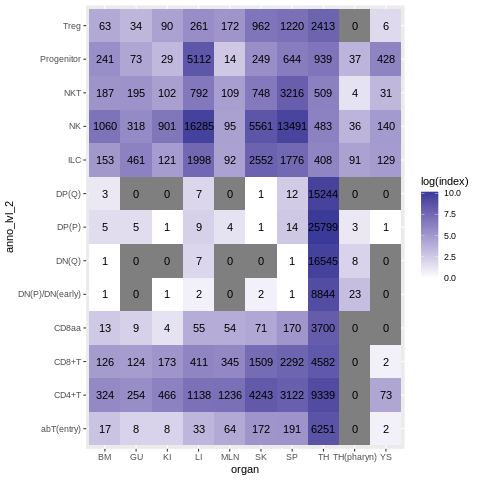

In [50]:
%%R -i df
head(df)
ggplot(df, aes(organ, anno_lvl_2, fill=log(index))) + 
geom_tile() +
geom_text(aes(label=index)) +
scale_fill_gradient2()

In [51]:
%%R -i adata_sub
adata_sub

class: SingleCellExperiment 
dim: 4042 5000 
metadata(0):
assays(1): X
rownames(4042): FGR CYP51A1 ... RP11-61G19.2 RP11-299P2.2
rowData names(2): GeneName GeneID
colnames(5000): FCAImmP7803021-GAATAAGGTAGCGTAG
  FCAImmP7851890-GTTTCTAAGCAATCTC ... FCAImmP7277560-CAGCATACACGGTAAG
  FCAImmP7851891-CGGGTCAAGAGTCTGG
colData names(8): anno_lvl_1 anno_lvl_2 ... method organ
reducedDimNames(2): PCA UMAP
altExpNames(0):


In [52]:
%%R
## Remove lowly expressed genes 
min_cells = 10
adata_sub = adata_sub[rowSums(assay(adata_sub, "X")) > min_cells,]
assay(adata_sub, "X") <- as.matrix(assay(adata_sub, "X"))

## Rename TH(pharyn) to TH
adata_sub$organ <- ifelse(adata_sub$organ ==  'TH(pharyn)', 'TH', as.character(adata_sub$organ))

# ## Exclude YS and KI
# adata_sub <- adata_sub[,adata_sub$organ!="YS"]
# adata_sub <- adata_sub[,adata_sub$organ!="KI"]

# ## Exclude TH specific cell types
# adata_sub <- adata_sub[,adata_sub$anno_lvl_2 %in% c("DN(P)/DN(early)", "DN(Q)", "DP(Q)", "DP(P)")]

In [40]:
%%R
convert_formula_to_model_matrix <- function(formula, col_data, reference_level=NULL){
  if(! is.null(reference_level)){
    has_ref_level <- vapply(col_data, function(x){
      any(!is.na(x) & x == reference_level)
    }, FUN.VALUE = FALSE)
    if(all(has_ref_level == FALSE)){
      stop("None of the columns contains the specified reference_level.")
    }
    col_data[has_ref_level] <- lapply(col_data[has_ref_level], function(col){
      if(is.character(col)){
        col <- as.factor(col)
      }
      stats::relevel(col, ref = reference_level)
    })
  }
  tryCatch({
    mm <- stats::model.matrix.default(formula, col_data)
  }, error = function(e){
    # Try to extract text from error message
    match <- regmatches(e$message, regexec("object '(.+)' not found", e$message))[[1]]
    if(length(match) == 2){
      stop("Object '", match[2], "' not found. Allowed variables are:\n",
           paste0(colnames(col_data), collapse = ", "))
    }else{
      stop(e$message)
    }
  })

  colnames(mm)[colnames(mm) == "(Intercept)"] <- "Intercept"
  mm
}

# m <- convert_formula_to_model_matrix(formula= ~ 1 + organ + anno_lvl_2 + (organ*anno_lvl_2), col_data=colData(adata_sub)) 

In [76]:
%%R
## Remove columns that sum to 0 in model matrix (e.g. tissue specific cell types)
is_zero_column <- DelayedMatrixStats::colCounts(m, value = 0) == nrow(m)
        
model_mat <- m[,which(colSums(m) > 2)]


In [81]:
%%R
ncol(model_mat)

[1] 74


In [61]:
%%R
fit <- glm_gp(adata_sub[c("CD8A"),], design = model_mat, on_disk = FALSE)
# fit_cd4 <- glm_gp(adata_sub[c("CD8A"),sample(colnames(adata_sub), 1000)], design = ~ 1 + organ + anno_lvl_2, on_disk = FALSE)
# fit_cd8 <- glm_gp(adata_sub[c("CD8A"),], design = ~ 1 + organ + anno_lvl_2, on_disk = FALSE)
summary(fit)


Error in handle_design_parameter(design, data, col_data, reference_level) : 
  The model matrix:
                                Intercept organGU organKI organLI organMLN organSK organSP organTH organYS anno_lvl_2CD4+T anno_lvl_2CD8+T anno_lvl_2CD8aa anno_lvl_2DN(P)/DN(early) anno_lvl_2DN(Q) anno_lvl_2DP(P) anno_lvl_2DP(Q) anno_lvl_2ILC anno_lvl_2NK anno_lvl_2NKT anno_lvl_2Progenitor anno_lvl_2Treg organGU:anno_lvl_2CD4+T organKI:anno_lvl_2CD4+T organLI:anno_lvl_2CD4+T organMLN:anno_lvl_2CD4+T organSK:anno_lvl_2CD4+T organSP:anno_lvl_2CD4+T organTH:anno_lvl_2CD4+T organYS:anno_lvl_2CD4+T organGU:anno_lvl_2CD8+T organKI:anno_lvl_2CD8+T organLI:anno_lvl_2CD8+T organMLN:anno_lvl_2CD8+T organSK:anno_lvl_2CD8+T organSP:anno_lvl_2CD8+T organTH:anno_lvl_2CD8+T organLI:anno_lvl_2CD8aa organMLN:anno_lvl_2CD8aa organSK:anno_lvl_2CD8aa organSP:anno_lvl_2CD8aa organTH:anno_lvl_2CD8aa organTH:anno_lvl_2DN(P)/DN(early) organTH:anno_lvl_2DN(Q) organSP:anno_lvl_2DP(P) organTH:anno_lvl_2DP(P) organTH

In [222]:
%%R -w 500
data.frame(summary(fit)$Beta)

     Intercept    organGU    organKI     organLI  organMLN    organSK
CD8A -1.806606 -0.3927672 -0.2936423 -0.04664605 0.1510903 -0.4196295
        organSP   organTH   organYS anno_lvl_2CD8.T anno_lvl_2CD8aa
CD8A -0.3044111 0.4542756 -1.202777        2.933218        2.720606
     anno_lvl_2DN.P..DN.early. anno_lvl_2DN.Q. anno_lvl_2DP.P. anno_lvl_2DP.Q.
CD8A                 -0.118408       0.4863538        2.944039        2.768339
     anno_lvl_2ILC anno_lvl_2NK anno_lvl_2NKT anno_lvl_2Progenitor
CD8A     0.2113589     1.955104      2.446594           -0.5028418
     anno_lvl_2Treg anno_lvl_2abT.entry.
CD8A       1.506564             1.430429


In [118]:
%%R -o coefficients
coefficients <- summary(fit)$Beta
res <- summary(fit)$deviances

In [119]:
coef_df = pd.DataFrame(coefficients, index=adata_sub.var_names)

ValueError: Shape of passed values is (2236, 22), indices imply (4042, 22)

In [ ]:
coef_df.max(1)

In [103]:
(adata_sub[:,"WNT16"].X > 0).toarray()

2

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(array([1998.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           2.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29

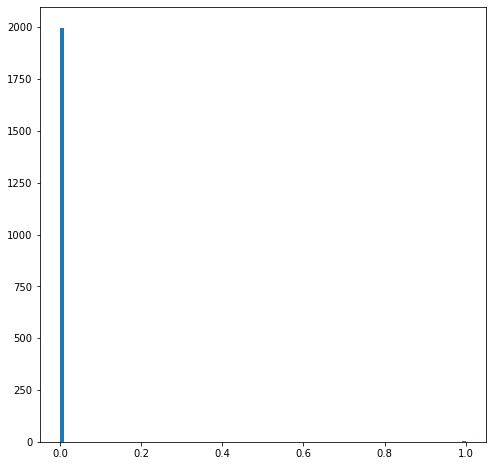

In [96]:
plt.hist(adata_sub[:,"WNT16"].X.toarray(), bins=100)

/opt/conda/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


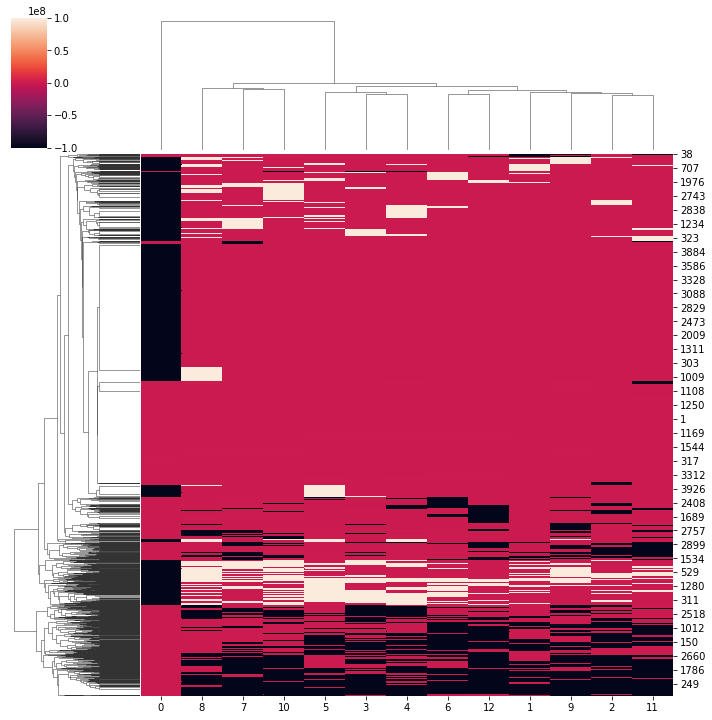

In [64]:
sns.clustermap(coefficients)

## Aggregate gene expression profiles by sample and celltypes

To use MEFISTO/MOFA

In [9]:
# group_by=["Sample", "anno_lvl_2", "organ"]
def anndata2pseudobulk(adata, group_by):
    if "log1p" in adata_nkt_raw.uns_keys():
        print("adata.X is in log-transformed, pseudobulking should be done on counts")
        return()
    ## Make obs for pseudobulk
    pseudobulk_obs = adata.obs[group_by].drop_duplicates()
    pseudobulk_obs.index = pseudobulk_obs[group_by].agg("-".join, axis=1)
    ## Add column to obs assigning cells to pseudobulk samples
    adata.obs["pseudobulk_sample"] = adata.obs[group_by].agg("-".join, axis=1)
    ## Sum counts from same sample
    sample_dummies = pd.get_dummies(adata.obs["pseudobulk_sample"]).values
    sample_dummies = scipy.sparse.csr_matrix(sample_dummies)
    pseudobulk_X = adata.X.T.dot(sample_dummies)
    ## Make new anndata object
    pseudobulk_adata = anndata.AnnData(pseudobulk_X.T, obs=pseudobulk_obs, var=adata.var)
    ## Add number of cells to obs 
    n_cells = adata.obs.groupby('pseudobulk_sample').count().iloc[:,0]
    n_cells.name = "n_cells"
    pseudobulk_adata.obs = pd.concat([pseudobulk_adata.obs, n_cells], axis=1)
    return(pseudobulk_adata)

In [10]:
pseudobulk_adata = anndata2pseudobulk(adata_nkt_raw, ["Sample", "anno_lvl_2", "organ","donor", "method"])

In [23]:
pseudobulk_obs = adata_nkt_raw.obs[["Sample", "anno_lvl_2", "organ","donor", "method","age","pseudobulk_sample"]].drop_duplicates()
pseudobulk_obs.index = pseudobulk_obs.pseudobulk_sample

In [26]:
pseudobulk_adata.obs = pseudobulk_obs.loc[pseudobulk_adata.obs_names] 

In [30]:
pseudobulk_adata.write_h5ad("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_raw_count.wGut.NKT_CLEAN.pseudobulk.h5ad")

Make model matrix

In [159]:
df = pseudobulk_adata.obs[['organ', 'anno_lvl_2']].reset_index().groupby(['organ', 'anno_lvl_2']).count().reset_index()

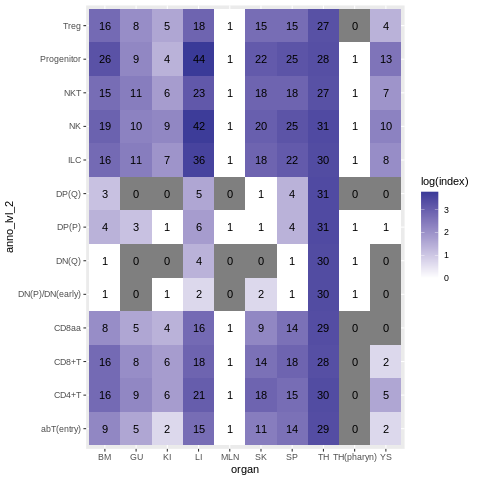

In [160]:
%%R -i df
head(df)
ggplot(df, aes(organ, anno_lvl_2, fill=log(index))) + 
geom_tile() +
geom_text(aes(label=index)) +
scale_fill_gradient2()

In [38]:
%%R -i pseudobulk_adata
pseudobulk_adata

class: SingleCellExperiment 
dim: 33694 1305 
metadata(0):
assays(1): X
rownames(33694): TSPAN6 TNMD ... RP11-107E5.4 RP11-299P2.2
rowData names(2): GeneName GeneID
colnames(1305): F21_LI_45P-NK-LI-F21-3GEX F21_LI_45P-CD4+T-LI-F21-3GEX
  ... F66-FMI-0-SC-1-Treg-GU-F66-3GEX F72-FMI-0-SC-1-DP(P)-GU-F72-5GEX
colData names(7): Sample anno_lvl_2 ... age pseudobulk_sample
reducedDimNames(0):
altExpNames(0):


In [54]:
%%R
m <- convert_formula_to_model_matrix(formula= ~ 1 + donor + method + organ + anno_lvl_2 + (organ*anno_lvl_2), col_data=colData(pseudobulk_adata)) 
## Remove columns that sum to 0 in model matrix (e.g. tissue specific cell types)
is_zero_column <- DelayedMatrixStats::colCounts(m, value = 0) == nrow(m)
model_mat <- m[,which(colSums(m) > 2)]
ncol(m)

[1] 154


In [41]:
%%R
assay(pseudobulk_adata) <- as.matrix(assay(pseudobulk_adata))

In [70]:
hvgs = adata_nkt.var_names


In [71]:
"CD4" in hvgs

True

In [83]:
markers = np.array(["CD4", "CD8A", "SPIB", "NKG7", "CCR9", "PTCRA", "RAG1", "TOX2", 'AREG', 'TLE1', 'IL4I1'])
[x for x in markers if x in hvgs]

['CD4',
 'CD8A',
 'SPIB',
 'NKG7',
 'CCR9',
 'PTCRA',
 'RAG1',
 'TOX2',
 'AREG',
 'TLE1',
 'IL4I1']

In [84]:
%%R -i markers
markers
fit <- glm_gp(pseudobulk_adata[markers,], design = model_mat, on_disk = FALSE)
# fit_cd4 <- glm_gp(adata_sub[c("CD8A"),sample(colnames(adata_sub), 1000)], design = ~ 1 + organ + anno_lvl_2, on_disk = FALSE)
# fit_cd8 <- glm_gp(adata_sub[c("CD8A"),], design = ~ 1 + organ + anno_lvl_2, on_disk = FALSE)
summary(fit)

glmGamPoiFit object:
The data had 11 rows and 1305 columns.
A model with 108 coefficient was fitted.

Beta:
            Min 1st Qu. Median 3rd Qu.   Max
Intercept -3.72  0.3532  2.247   2.824 3.340
 donorF21 -1.87 -0.9469  0.371   0.491 2.996
 donorF22 -0.93 -0.0806  0.185   0.664 0.864
...

deviance:
 Min 1st Qu. Median 3rd Qu.  Max
 545     793    942    1334 1385

overdispersion:
  Min 1st Qu. Median 3rd Qu.  Max
 1.22    1.52   3.08    4.35 6.51

Shrunken quasi-likelihood overdispersion:
  Min 1st Qu. Median 3rd Qu. Max
 0.41   0.497  0.999     1.4 2.1

size_factors:
   Min 1st Qu. Median 3rd Qu. Max
 0.001    0.15  0.891    4.37 912

Mu:
      Min 1st Qu. Median 3rd Qu.    Max
 1.31e-19   0.395   3.48    29.8 477353



In [88]:
%%R -o coefficients 
coefficients <- summary(fit)$Beta
res <- summary(fit)$deviances

rownames(coefficients) <- markers
colnames(coefficients) <- colnames(model_mat)
coefficients <- data.frame(coefficients)

# rownames(res) <- genes
# colnames(res) <- colnames(model_mat)
# res <- data.frame(res)

<AxesSubplot:>

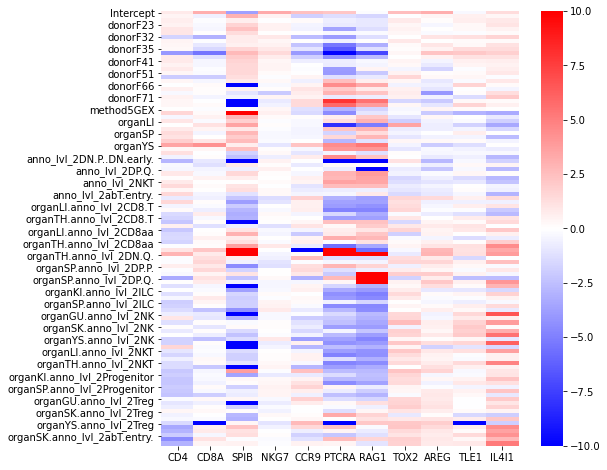

In [89]:
sns.heatmap(coefficients.T, cmap="bwr", vmax=10, vmin=-10)

In [93]:
import re
organ_col_mask = [bool(re.match("^organ..$", x)) for x in coefficients.T.index]
anno_col_mask = [bool(re.match("^anno_lvl_2", x)) for x in coefficients.T.index]
int_col_mask = [bool(re.match("^organ...anno_lvl_2", x)) for x in coefficients.T.index]

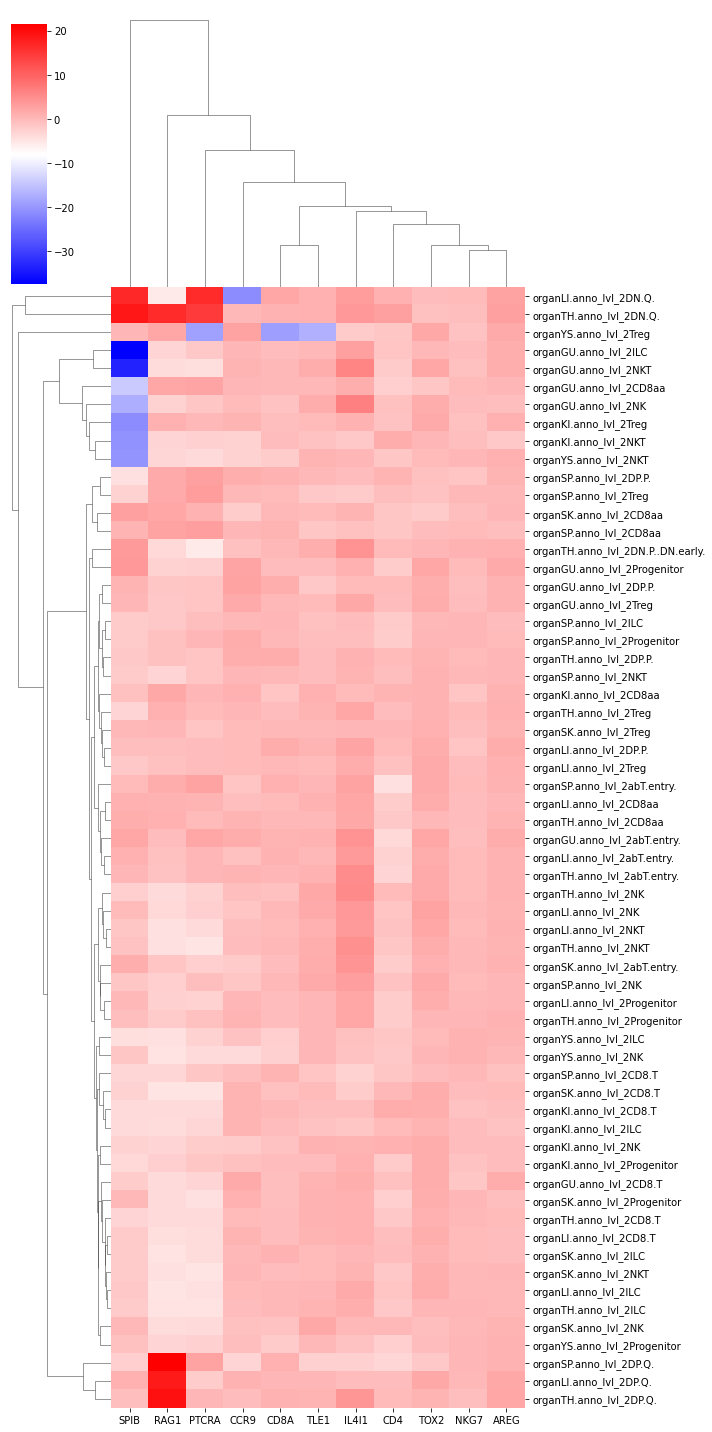

In [103]:
sns.clustermap(coefficients.T[int_col_mask], cmap="bwr", figsize=[10,20])

<AxesSubplot:>

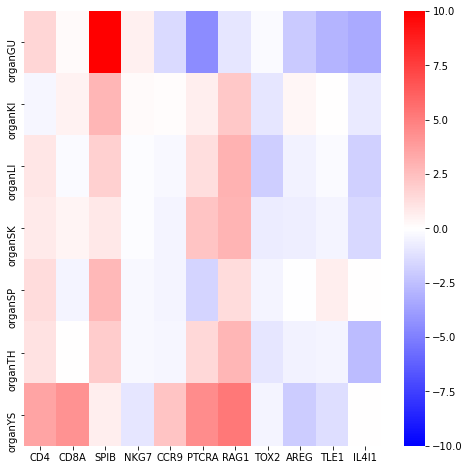

In [92]:
sns.heatmap(coefficients.T[organ_col_mask], cmap="bwr", vmax=10, vmin=-10)
# sns.clustermap(coefficients.T[anno_col_mask], cmap="bwr", vmax=10, vmin=-10)

In [113]:
df = pseudobulk_adata.obs

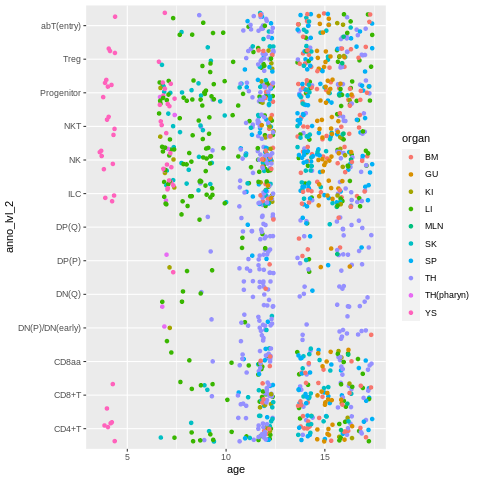

In [117]:
%%R -i df
ggplot(df, aes(age, anno_lvl_2, color=organ)) + 
geom_jitter()

## Save lymphoid matrix 4 LMM

Run by Natsuhiko

In [118]:
adata_lymph = sc.read_h5ad("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210118.LYMPHOID.h5ad")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [119]:
## Add annotations

anno_b = pd.read_csv("../manual_annotation/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210118.B_CLEAN_CLEAN.batchCorrected_annotation.csv")
anno_b.index = anno_b['index']

anno_nkt = pd.read_csv("../manual_annotation/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210118.NKT_CLEAN.batchCorrected_annotation.csv")
anno_nkt.index = anno_nkt['index']

In [140]:
anno_lymph = pd.concat([anno_nkt, anno_b]).drop_duplicates()

In [146]:
adata_lymph = adata_lymph[anno_lymph.index]

In [149]:
adata_lymph.obs = pd.concat([adata_lymph.obs, anno_lymph], 1)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [157]:
adata_lymph.obs.loc[adata_lymph.obs.organ=="TH(pharyn)","organ"] = "TH"

In [159]:
adata_lymph.obs[["Sample", "donor", "organ", "anno_lvl_2", "age", "method"]].to_csv("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210118.LYMPHOID.lmm_metadata.csv")

In [164]:
import scipy.io
scipy.io.mmwrite("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210118.LYMPHOID.lmm_logcounts.mtx", adata_lymph.X)

In [165]:
anno_b.iloc[np.where(anno_b.index.isin(anno_nkt.index))].value_counts('anno_lvl_2')

anno_lvl_2
MPP              4117
ELP/PRE_PRO_B     928
MATURE_B           22
PRO_B               3
PRO_TO_PRE_B        2
LARGE_PRE_B         1
dtype: int64

### Model by JP

In [20]:
class linear_regression():
    
    def __init__(self,adata):
        self.adata = adata
        self.df = adata.obs
        self.X_exp = adata.X
        self.LR_dict = {}
    
    def celltype_organ(self, anno_key, celltype, others=['organ','method']):
        from sklearn.linear_model import Ridge
        
        self.df['is_%s'%celltype] = [str(x) for x in self.df[anno_key]==celltype] # cell type term
        self.df['%s_organ'%celltype] = [x+'_'+y for x,y in zip(self.df['is_%s'%celltype],self.df['organ'])] # interaction term
        cat = self.df[['is_%s'%celltype, '%s_organ'%celltype] + others] # add organ term and others
        LR = Ridge()
        dummy = pd.get_dummies(cat, drop_first=False)
        LR.fit(dummy, self.X_exp)
        params = list(dummy.columns)
        ct_dict = {'LR': LR, 'params': params}
        self.LR_dict[celltype] = ct_dict
        
    def celltype_organ_2(self, anno_key, celltype, others=['method']):
        from sklearn.linear_model import Ridge
        
        self.df['is_%s'%celltype] = [str(x) for x in self.df[anno_key]==celltype] # cell type term
        self.df['%s_organ'%celltype] = [x+'_'+y for x,y in zip(self.df['is_%s'%celltype],self.df['organ'])] # interaction term
        cat = self.df[['%s_organ'%celltype] + others] # add organ term and others
        LR = Ridge()
        dummy = pd.get_dummies(cat, drop_first=False)
        LR.fit(dummy, self.X_exp)
        params = list(dummy.columns)
        ct_dict = {'LR': LR, 'params': params}
        self.LR_dict[celltype] = ct_dict
    
    def show_param_genes(self, celltype, param, toshow=20, output=False):
        coef = self.LR_dict[celltype]['LR'].coef_[:,self.LR_dict[celltype]['params'].index(param)]
        order = np.argsort(-coef)
        names = adata.var_names[order][:toshow]
        values = coef[order][:toshow]
        print(['%s:%.2f'%(x,y) for x,y in zip(names,values)])
        if output:
            return names, values
    
    def violin_plot(self, celltype, gene):
        LR = self.LR_dict[celltype]['LR']
        params = self.LR_dict[celltype]['params']
        
        Exp = self.adata.raw.X
        exp = Exp[:,self.adata.raw.var_names==gene].todense().A1

        self.df[gene+'_exp'] = exp

        fig = plt.figure(figsize=(8,2))
        ax = plt.subplot(111)
        sns.violinplot(x='is_%s'%(celltype),y=gene+'_exp',
                       hue='organ',data = self.df,
                       scale='width',linewidth=0,inner=None,rasterized=True,cut=0,ax=ax)
        plt.xticks(rotation=0)
        plt.grid(False)
        plt.xlabel('')
        ax.legend(bbox_to_anchor=(1.2, 1.05))
        plt.show()

        gidx = self.adata.var_names==gene

        cf = LR.coef_[gidx][0]
        cf_idx = np.argsort(-cf)
        print('\n'.join(['%.2f : %s'%(a,b) for a,b in zip(cf[cf_idx],np.array(params)[cf_idx])]))


In [ ]:
linear_regression(adata)